<a id="top"></a>
# Surveying dust structure via GALEX MIS - Part 2
***

## Learning goals

By the end of this tutorial you will be able to:

- Understand UV images and how they are useful to study dust
- Create a mosaic from several GALEX MIS images
- Learn how to match images using their central coordinates 
- Use masks for circular images

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. 

**GALEX Medium Imaging survey (MIS) background**: Single orbit exposures (1,500s) of 1000 square degrees in positions that match the Sloan Digital Sky Survey (SDSS). These images present a higher resolution in comparison with AIS since their exposure time was longer.

**Defining some terms:**

- **Intensity map**: image that displays the photons per pixel per second corrected for the relative response of the instrument used.

Clouds can be visible in UV when they are found close to hot stars. The objective of this tutorial is to extract and display an intensity map image of a high-latitude cloud retrieved from GALEX MIS. High-latitude clouds (Galactic latitude: $|b| > 20-30º$) are interesting because they are considered ideal candidates to study triggered star formation.

This tutorial is divided in two parts. In Part 1, you will learn how to navigate the GALEX MIS database through the MAST portal, download and display the intensity maps for specific coordinates, and understand how to properly display the contents of these images. In Part 2, we will use this method to create a mosaic by combining several of these images and study dust clouds.

## Table of Contents
* [Imports](#Imports)
* [Target: MBM 15](#Target:-MBM-15)
* [GALEX MIS - Coordinate query and data download](#GALEX-MIS---Coordinate-query-and-data-download)
* [Constructing the mosaic](#Constructing-the-mosaic)
    * [Checking orientation](#Checking-orientation)
    * [Saving images to local](#Saving-images-to-local)
    * [Circular mask creation](#Circular-mask-creation)
    * [Expanded image](#Expanded-image)
    * [Limits of image - Coordinates](#Limits-of-image---Coordinates)
    * [Save expanded image to local](#Save-expanded-image-to-local)
    * [Transforming RA/Dec into image coordinates](#Transforming-RA/Dec-into-image-coordinates)
    * [Final mosaic](#Final-mosaic)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

- `astropy` to use tools needed for performing astronomy and astrophysics with Python, including handling fits files, defining coordinates or choosing the right limits for image visualization.
- `Observations` from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).
- `os` to  use operating system dependent functionality, such as unzipping files.
- `matplotlib` to visualize images.
- `numpy` to manipulate arrays.
- `PIL` to combine multiple images together

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.mast import Observations
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.visualization import ZScaleInterval
import numpy as np
from PIL import Image, ImageDraw

## Target: MBM 15

The objective of this tutorial is to create a mosaic of a high-latitude cloud using different UV images retrieved from GALEX MIS. The GALEX MIS products can be accesed through `astroquery.mast`. The whole process to get an individual image and display it is explained in Part 1 of this tutorial, the reader is encouraged to complete the previous tutorial before continuing this one if they haven't done it yet. 

Now, let's start with our target, <a href="http://simbad.u-strasbg.fr/simbad/sim-id?Ident=mbm+15&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id">the molecular cloud MBM 15</a>. Let's start with the coordinates that SIMBAD provides for our selected target (GAL coordinates, ep = J2000) are: 

- Galactic longitude: 191.6657 deg
- Galactic latitude: -52.2938 deg

## GALEX MIS - Coordinate query and data download

As mentioned before, the whole process of downloading and displayed the images from the MAST database has been explained in the previous tutorial, so please refer to Part 1 if you have any doubts about this process, since this is not the main goal of Part 2 and this process will be introduced with no further explanations. 

The only variation from part 1 is that since we want to construct a mosaic centered on the coordinates of our target, we will increase the radius used for the query up to 1 deg, and download all images found inside this radius. 

In [2]:
coord_gal = SkyCoord(191.6657, -52.2938, unit='deg', frame='galactic')
coord_icrs = coord_gal.transform_to('icrs')
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord_icrs,project='MIS',radius="1 deg")
data_products = Observations.get_product_list(obs)
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
data_products_mrp.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,325,GALEX,image,2422974120422539264,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/01-main/0001-img/07-try/MISDR1_18916_0459-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_18916_0459-fd-int.fits.gz,11609897,325,PUBLIC,2
1,325,GALEX,image,2422974120422539264,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/01-main/0001-img/07-try/MISDR1_18916_0459-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_18916_0459-nd-int.fits.gz,16323829,325,PUBLIC,2
2,2838,GALEX,image,2920305219898179584,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17464-MISWZS03_18917_0284/d/01-main/0001-img/07-try/MISWZS03_18917_0284-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_18917_0284-fd-int.fits.gz,4409502,2838,PUBLIC,2
3,2838,GALEX,image,2920305219898179584,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17464-MISWZS03_18917_0284/d/01-main/0001-img/07-try/MISWZS03_18917_0284-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_18917_0284-nd-int.fits.gz,10302535,2838,PUBLIC,2
4,2851,GALEX,image,2920762616735334400,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17477-MISWZS03_27307_0183/d/01-main/0001-img/07-try/MISWZS03_27307_0183-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_27307_0183-fd-int.fits.gz,9600414,2851,PUBLIC,2
5,2851,GALEX,image,2920762616735334400,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17477-MISWZS03_27307_0183/d/01-main/0001-img/07-try/MISWZS03_27307_0183-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_27307_0183-nd-int.fits.gz,16104455,2851,PUBLIC,2
6,2915,GALEX,image,2923049600921108480,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17542-MISWZS03_28512_0284/d/01-main/0001-img/07-try/MISWZS03_28512_0284-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28512_0284-fd-int.fits.gz,9895927,2915,PUBLIC,2
7,2915,GALEX,image,2923049600921108480,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17542-MISWZS03_28512_0284/d/01-main/0001-img/07-try/MISWZS03_28512_0284-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28512_0284-nd-int.fits.gz,15593462,2915,PUBLIC,2
8,2916,GALEX,image,2923084785293197312,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17543-MISWZS03_28513_0284/d/01-main/0001-img/07-try/MISWZS03_28513_0284-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28513_0284-fd-int.fits.gz,11000571,2916,PUBLIC,2
9,2916,GALEX,image,2923084785293197312,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17543-MISWZS03_28513_0284/d/01-main/0001-img/07-try/MISWZS03_28513_0284-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28513_0284-nd-int.fits.gz,15407217,2916,PUBLIC,2


It should be noted that each source has two entries in the previous table, one corresponding to the NUV image and one for the FUV image. In this tutorial we will select the FUV images, but the reader is encouraged to repeat this process using the NUV images and compare the obtained results.

In [3]:
filename = []
for i in range(0,len(data_products_mrp),2):
    yourProd = data_products_mrp[i]
    table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
    filename.append(table['Local Path'][0])

Now we will retrieve both the image and the header of our images. The header contains important information that will help us correctly construct our mosaic, such as the length of the axis in pixels ($naxis$), the increase in degrees per pixel ($cdelt$), the central pixel ($crpix$) and the coordinates of the center of our image in (RA, Dec) form ($crval$).

For further detail please refer to Part 1 of this tutorial where this process in explained in more detail.

In [4]:
n = len(filename)

images_mbm15 = []
header_mbm15 = []
RA1_mbm15 = np.zeros(n)
RAf_mbm15 = np.zeros(n)
Dec1_mbm15 = np.zeros(n)
Decf_mbm15 = np.zeros(n)
vmin_mbm15 = np.zeros(n)
vmax_mbm15 = np.zeros(n)
RAc_mbm15 = np.zeros(n)
Decc_mbm15 = np.zeros(n)

for i in range(n):
    os.system("gunzip " + filename[i])
    
    with fits.open(filename[i][:-3]) as hdulist: 
        header = hdulist[0].header
        header_mbm15.append(header)
        image = hdulist[0].data
        images_mbm15.append(image)
        
    naxis1 = header['NAXIS1']
    naxis2 = header['NAXIS2']
    cdelt1 = header['CDELT1']
    cdelt2 = header['CDELT2']
    crpix1 = header['CRPIX1']
    crpix2 = header['CRPIX2']
    crval1 = header['CRVAL1']
    RAc_mbm15[i] = crval1
    crval2 = header['CRVAL2']
    Decc_mbm15[i] = crval2
    
    # Initial RA - Pixel 1
    RA1_mbm15[i] = crval1 - (crpix1-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    # Final RA - Last Pixel 
    RAf_mbm15[i] = crval1 + (naxis1+1-crpix1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
    
    # Initial Dec - Pixel 1
    Dec1_mbm15[i] = crval2 - (crpix2-1)*cdelt2
    # Final Dec - Last Pixel 
    Decf_mbm15[i] = crval2 + (naxis2+1-crpix2)*cdelt2
    
    cut = image[1850:-1850,1850:-1850]
    interval = ZScaleInterval(nsamples=cut.size, contrast=0.75, max_reject=0.5)
    vmin_mbm15[i], vmax_mbm15[i] = interval.get_limits(cut)

## Constructing the mosaic

### Checking orientation

Since we want to construct a mosaic with different images, we need to make sure all of them are oriented in the same way. As it is explained in the [GALEX Data Drescription page at MAST](http://galex.stsci.edu/gr6/?page=ddfaq), the fits header of GALEX follow the [World Coordinate System (WCS)](https://danmoser.github.io/notes/gai_fits-imgs.html#wcs-rotation) standard. This means that the information regarding image rotation is contained in the header of the images, especifically under the parameter 'CROTA2', which refers to the rotation of the horizontal and vertical axes in degrees. So let's check all our images:

In [5]:
for i in range(len(header_mbm15)):
    print('Image '+str(i+1)+': '+repr(header_mbm15[i][23:24]))

Image 1: CROTA2  =                   0.                                                  
Image 2: CROTA2  =                   0.                                                  
Image 3: CROTA2  =                   0.                                                  
Image 4: CROTA2  =                   0.                                                  
Image 5: CROTA2  =                   0.                                                  
Image 6: CROTA2  =                   0.                                                  
Image 7: CROTA2  =                   0.                                                  
Image 8: CROTA2  =                   0.                                                  
Image 9: CROTA2  =                   0.                                                  


Great! This means all of our images are oriented in the same way, so we can directly work with them without having to perform any rotation.

### Saving images to local

Because we will be using [`PIL`](https://pillow.readthedocs.io/en/stable/reference/Image.html) to create our mosaic, we need to individually save the images to our local directory and then open them as _.jpg_, and we will save them without the axis as a first step. The information about their coordinates will be included in the final mosaic. Now, let's save all the images except for the first one, which we will use as the central one in the mosaic.

_**Note**: in order to ensure a smooth mosaic, we will use the vmin and vmax corresponding to the first image, this will ensure all images will have the same constrast level._

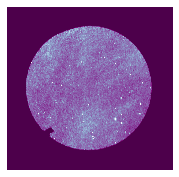

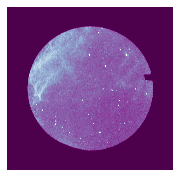

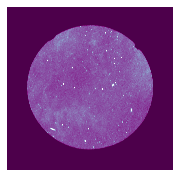

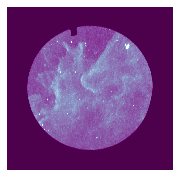

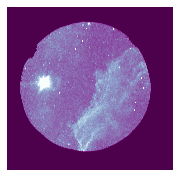

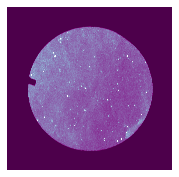

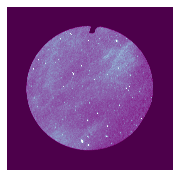

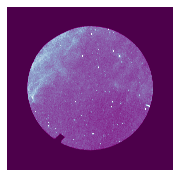

In [6]:
for i in range(1,len(RA1_mbm15)):
    plt.figure(figsize = (3,3),frameon=False)
    ax = plt.gca()
    ax.set_axis_off()
    plt.imshow(images_mbm15[i], extent=[RA1_mbm15[i], RAf_mbm15[i], Dec1_mbm15[i], Decf_mbm15[i]], vmin=vmin_mbm15[0], vmax=vmax_mbm15[0], cmap='BuPu_r',origin='lower')
    plt.savefig('mbm15_'+str(i)+'.jpg',pad_inches=0,bbox_inches='tight')
    plt.show()

### Circular mask creation

Let's create a mask for each image in the form of a circle. We will use this to only paste the circular part of the Draco images, which is where the actual image is contained, into the mosaic. For this we will use `Image.new()`, this method creates a new image for a given mode (in our case "L" because we will create it in black and white) and size, which will be the same as its corresponding image. 

In this new image we will then draw a circle, which will be our actual mask, for this we will use `draw.ellipse()`. The parameters that we need to provide are the four points to define the box in which the ellipse will be contained and the parameter _fill_ specifies the color with which the form will be filled. Since we are using the black and white mode, it does not really matter as long as it is different from black, so we can use any color.

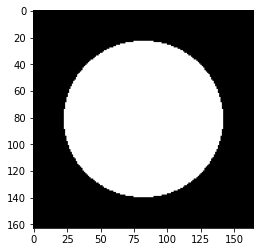

In [7]:
mask_im = []
n = len(filename)

for i in range(1,n):
    im2 = Image.open('mbm15_'+str(i)+'.jpg')
    mask = Image.new("L", im2.size)
    size = mask.size
    draw = ImageDraw.Draw(mask)
    draw.ellipse((size[0]/7, size[1]/7, size[0]-size[0]/7, size[1]-size[1]/7), fill=255)
    mask_im.append(mask)

plt.figure()
plt.imshow(mask_im[0],cmap='binary_r')
plt.show()

### Expanded image

In order to create our mosaic, let's add zeros to our central image to expand the field of view. We will use this expanded image to paste the additional images in it. So from the size of our image, we will create an image that is 3 times as big in width and height, this can be done as follows:

In [8]:
w = len(images_mbm15[0])
new_zeros = np.zeros((w,w))
new_image = np.append(images_mbm15[0], new_zeros, axis = 0)
new_image = np.insert(new_image,0,new_zeros,axis= 0)
new_zeros2 = np.zeros((w,3*w))
new_image = np.insert(new_image,0,new_zeros2,axis= 1)
new_image = np.insert(new_image,2*w,new_zeros2,axis= 1)

### Limits of image - Coordinates

We need to update the limits of the expanded image, which is 3 times the size of our original one, so we can simply do the following:

In [9]:
naxis1 = header_mbm15[0]['NAXIS1']
naxis2 = header_mbm15[0]['NAXIS2']
cdelt1 = header_mbm15[0]['CDELT1']
cdelt2 = header_mbm15[0]['CDELT2']
crpix1 = header_mbm15[0]['CRPIX1']
crpix2 = header_mbm15[0]['CRPIX2']
crval1 = header_mbm15[0]['CRVAL1']
crval2 = header_mbm15[0]['CRVAL2']

# Initial RA - Pixel 1
RA1 = crval1 - (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
# Final RA - Last Pixel 
RAf = crval1 + (crpix1*3-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))

# Initial Dec - Pixel 1
Dec1 = crval2 - (crpix2*3-1)*cdelt2
# Final Dec - Last Pixel 
Decf = crval2 + (crpix2*3-1)*cdelt2

### Save expanded image to local

Even though now we have the correct coordinate limits, we won't use them until we create our final mosaic, so for now let's save our expanded image without the axis reference:

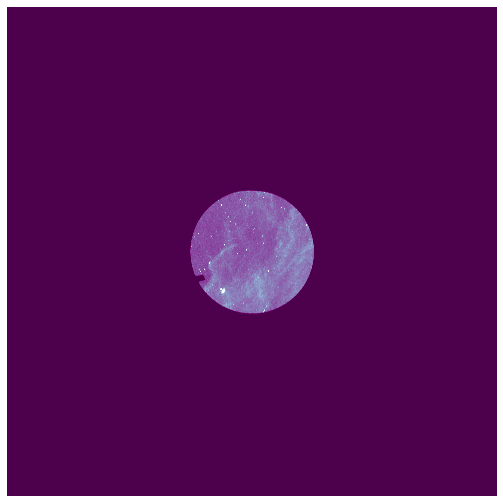

In [10]:
plt.figure(figsize = (9,9),frameon=False)
ax = plt.gca()
plt.imshow(new_image, vmin=vmin_mbm15[0], vmax=vmax_mbm15[0], cmap='BuPu_r',origin='lower')
ax.set_axis_off()
plt.savefig('expanded.pdf',pad_inches=0,bbox_inches='tight',dpi = 900)
plt.show()

### Transforming RA/Dec into image coordinates

We know the center of the additional images in the form (RA, Dec) so we should be able to use this information in order to correctly place them in our mosaic. However, when we use the method `paste` from the [`PIL`](https://pillow.readthedocs.io/en/stable/reference/Image.html) package, we need to specify the coordinates corresponding to the upper left cornerof our image. This means that the coordinates (0,0) are not placed in the middle of our image, let's see this through an example using the expanded image and one of the additional ones from the MBM 15 cloud:

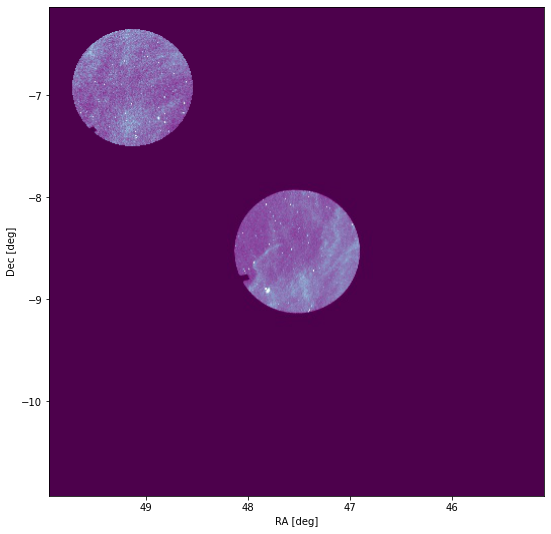

In [11]:
im_exp = Image.open('expanded.jpg')
im1 = Image.open('mbm15_1.jpg')

im_exp.paste(im1,(0,0),mask_im[-1])

plt.figure(figsize=(9,9))
ax = plt.gca()
plt.imshow(im_exp,extent=[RA1,RAf,Dec1,Decf])
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.show()

See how the additional image that corresponds to the image (0,0) coordinates is placed towards the upper left? If for example we wanted to place the image exactly over the central one we would need to give the coordinates of half the size of the extended image minus half the size of our first additional image. Let's see this through an example also:

_**Note**: the coordinates provided for `paste` should be integer values._

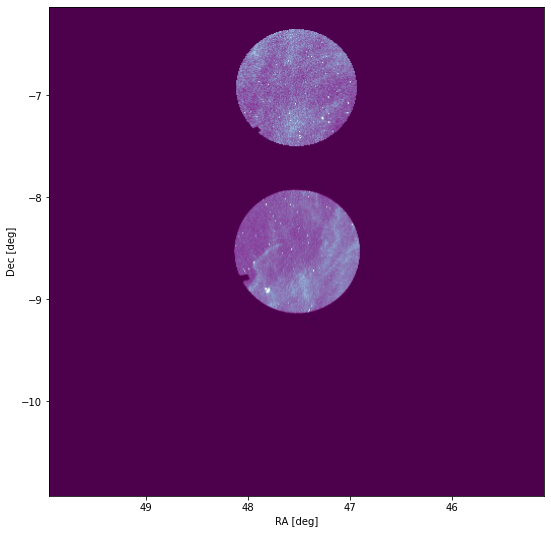

In [12]:
im_exp = Image.open('expanded.jpg')
im1 = Image.open('mbm15_1.jpg')

im_exp.paste(im1,(int(im_exp.size[0]/2-im1.size[0]/2),0),mask_im[0])

plt.figure(figsize=(9,9))
ax = plt.gca()
plt.imshow(im_exp,extent=[RA1,RAf,Dec1,Decf])
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.show()

By using this information, we can create a function that will automatically transform the central coordinates of our images in the (RA,Dec) format into the correct image ones to use them in `paste`:

In [13]:
def getImCoord(coord_RA,coord_Dec, RA1, RAf, Dec1, Decf,image,extended_image):
    
    """
    Transforms coordinates in (RA, Dec) format into image coordinates to be used as input for the paste method from PIL
    Inputs:
    :param coord_RA, coord_Dec: coordinates of target (Right Ascension and Declination)
    :type coord_RA, coord_Dec: float
    :param RA/Dec1, RA/Decf: coordinate limits of image for the RA/Dec axis
    :type RA/Dec1, RA/Decf: float
    :param image/extended_image: 2D arrays corresponding to the image we want to correctly place and the extended image we will place it on
    :type image/extended_image: PIL Jpeg image file
    
    Outputs: 
    :return: ImCoord_RA, ImCoord_Dec - Image coordinates
    :rtype: float
    """
    
    RAx = np.array([RA1,RAf])
    pixx = np.array([-image.size[0]/2,extended_image.size[0]-image.size[0]/2])
    m_RA, b_RA = np.polyfit(RAx, pixx, 1)
    ImCoord_RA = m_RA*coord_RA+b_RA
    
    Decx = np.array([Dec1,Decf])
    pixy = np.array([extended_image.size[1]-image.size[1]/2,-image.size[1]/2])
    m_Dec, b_Dec= np.polyfit(Decx, pixy, 1)
    ImCoord_Dec = m_Dec*coord_Dec+b_Dec
    
    return ImCoord_RA, ImCoord_Dec

Let's see how this works for our first image:

In [14]:
Im_RA = np.zeros(n)
Im_Dec = np.zeros(n)

im = Image.open('mbm15_1.jpg')
Im_RA[1], Im_Dec[1] = getImCoord(RAc_mbm15[1],Decc_mbm15[1], RA1, RAf, Dec1, Decf,im,im_exp)
print('(RA, Dec) = ('+str(RAc_mbm15[1])+','+str(Decc_mbm15[1])+') deg -> ('+str(Im_RA[1])+','+str(Im_Dec[1])+')')

(RA, Dec) = (47.03868,-9.28933) deg -> (210.76610532728228,240.5109778665044)


We have converted our coordiantes in RA/Dec to image pixels, so now we can directly use this to paste our images in the expanded mosaic! Let's do it for the rest of the images now:

In [15]:
for i in range(2,n):
    im = Image.open('mbm15_'+str(i)+'.jpg')
    Im_RA[i], Im_Dec[i] = getImCoord(RAc_mbm15[i],Decc_mbm15[i], RA1, RAf, Dec1, Decf,im,im_exp)

### Final mosaic

Now that we have all the ingredients to construct the final mosaic, let's put it all together:

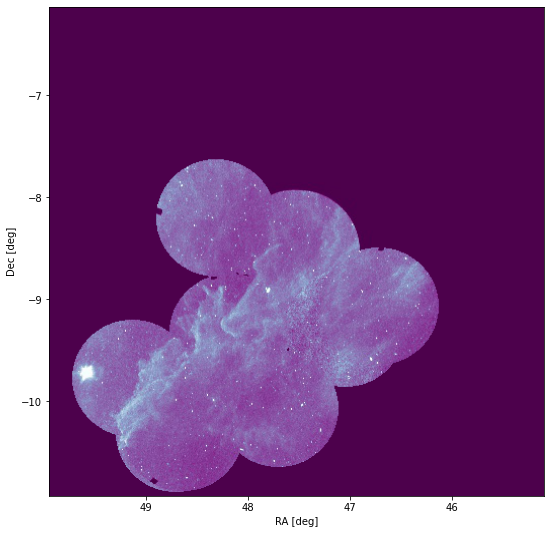

In [16]:
im_exp = Image.open('expanded.jpg')

for i in range(1,n):
    im = Image.open('mbm15_'+str(i)+'.jpg')
    im_exp.paste(im,(int(Im_RA[i]), int(Im_Dec[i])), mask_im[i-1])

plt.figure(figsize=(9,9))
ax = plt.gca()
plt.imshow(im_exp, extent=[RA1,RAf,Dec1,Decf])
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.savefig('mbm15_mosaic.jpg',bbox_inches='tight',dpi = 1100)
plt.show()

Finally, we have our mosaic! This image corresponds to the 
[Molecular cloud MBM 15](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=mbm+15&submit=submit+id). This molecular cloud belong to the Orion-Eridanus superbubble, west of the Orion Nebula. More information about this can be found in [Joubaud et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...631A..52J/abstract). 

## Exercises

Now that we have seen the whole process, let's try to do the same for the same target, but this time let's use the NUV images instead of the FUV images.

Here are again the coordinates that SIMBAD provides for the [MBM 15](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=mbm+15&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) (Gal. coordinates, ep = J2000):

- Galactic longitude: 191.6657 deg
- Galactic latitude: -52.2938 deg

### 1. Coordinate query and data download

Following the steps shown before, perform a query in the GALEX MIS database and download the NUV or FUV intensity maps corresponding to the coordinates provided. Remember to choose a wide radius for the query in order to construct the final mosaic.

In [17]:
# You can copy, paste and modify the code corresponding to this part that we used before here


_**Note**: don't forget to transform the coordinates from the galactic to the icrs frame!_

### 2. Check the orientation of the images

As we did before, check the orientation of the image and make the necessary adjustments if the orientations do not coincide:

In [18]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 3. Save non-central images to local

In order to use the `paste` method, we first need to save the additional images to our local. The central image is the fist one retrieved from the database, so let's save the rest of the images to our local directory in order to use them later. Remember you need to provide the filename which will be used to save the image to your local directory when using `savefig` from `matplotlib`.

In [19]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 4. Generate the masks for the circular images

Since we are working with circular images, in order to paste them into our extended image we need to only use the part of the image that actually contains information. In order to do this, let's use circular masks as before. Create a circular mask for each of the images retrieved as shown previously.

In [20]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 5. Create an expanded image from the central one

Using the central image (the first one retrieved from the database), create an extended image by included 0s in the 2D array corresponding to the retrieved intensity map as we did before.

In [21]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 6. Obtain the limits of the expanded image and save it

Using the technique introduced in Part 1 of this tutorial, and briefly introduced in Part 2 also, obtain the new limits of the extended image we just created using the coordinates of the central image (RA, Dec).

In [22]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 7. Transform RA, Dec coordinates into image coordinates

Lastly, we need to transform the central coordiantes of the images in order to correctly place them in the mosaic. You can use the function proposed before in this section.

In [23]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 8. Display the final mosaic

Let's put together everything and display the final mosaic!

In [24]:
# You can copy, paste and modify the code corresponding to this part that we used before here


As we can see in this image, the dust cloud that was clearly present in the FUV images, vaguely shows up in the NUV images. This is due to the fact that FUV images cover the wavelength range 900–2150 Å while NUV cover 1650-3200 Å, and since a good rule of thumb is that the dust size in the image is around the wavelength used for the observation, this serves us to put a preliminary upper limit to the dust grain size!

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://galex.stsci.edu/GR6/">GALEX via MAST</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: Tutorial, mosaic, dust <br>
**Last Updated**: Sep 2022 <br>
**Next review**: Apr 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>